# Development of polymer building, including monomer and bonding spec

In [7]:
# Supressing annoying warnings (!must be done first!)
import warnings
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER

logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)

from rdkit import Chem

from polymerist import rdutils
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.labeling import atomwise, molwise
from polymerist.rdutils.labeling.molwise import assign_ordered_atom_map_nums
from polymerist.rdutils.bonding import (
    portlib,
    dissolution,
    substitution,
    permutation,
    identification,
)
from polymerist.rdutils.bonding._bonding import combined_rdmol

# Port-binding rules

## Test structures

In [8]:
# some "normal" molecules for testing
H  = Chem.MolFromSmarts('[#1]-[1#0]')
OH = Chem.MolFromSmarts('[#1]-[O]-[2#0]')
METHYL = Chem.MolFromSmarts('[#6](-[2#0])(-[2#0])(-[3#0])(-[1#0])')
CARBONYL = Chem.MolFromSmarts('[#6]-[#6](=[#8])-[1#0]')
WITTIG = Chem.MolFromSmarts('[#6](=[1#0])(-[2#0])(-[#1])')
WITTIG_DUAL = Chem.MolFromSmarts('[#6](=[1#0])(-[#7](-[#1])(-[#1]))(-[#1])')

TEST_MOLS_NORMAL = (
    H,
    OH,
    METHYL,
    WITTIG,
    WITTIG_DUAL,
    CARBONYL
)

# Pathological examples for debug
DOUBLE_MID = Chem.MolFromSmarts('[#6](-[1#0])(-[#1])=[#0]-[#6](-[#1])(-[#1])(-[2#0])')
NEUTRONIUM = Chem.MolFromSmarts('[#0]-[#0]')
GHOST_WATER = Chem.MolFromSmarts('[#1]-[#0]-[#1]')

TEST_MOLS_PATHO = (
    DOUBLE_MID,
    NEUTRONIUM,
    GHOST_WATER
)

# COMBINE FOR UNIVERSAL TESTING
TEST_MOLS = (
    *TEST_MOLS_NORMAL,
    *TEST_MOLS_PATHO
)

1


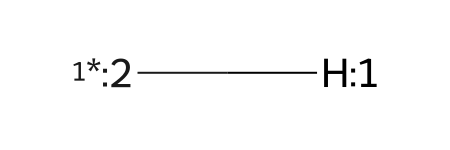

1


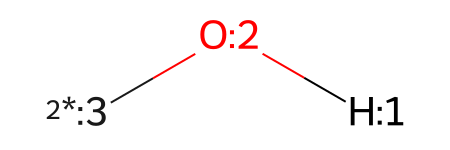

4


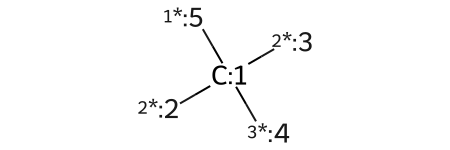

2


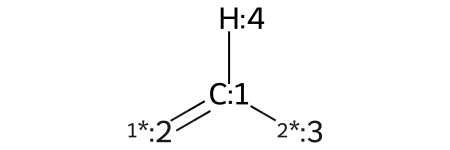

1


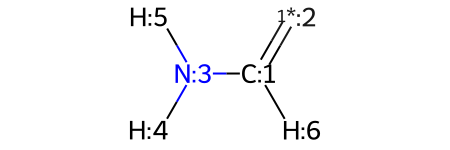

1


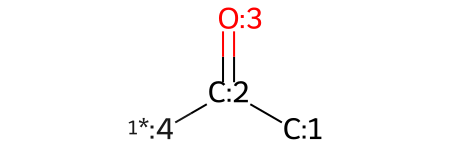

2


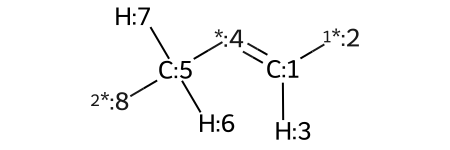

0


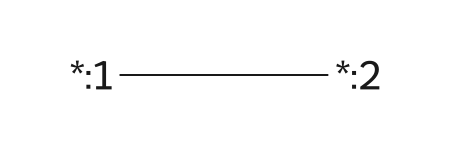

0


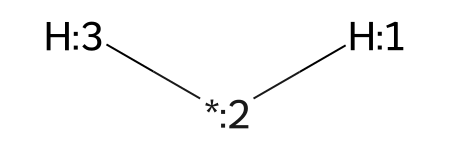

In [9]:
rdkdraw.disable_substruct_highlights()

for mol in TEST_MOLS:
    assign_ordered_atom_map_nums(mol, in_place=True)
    print(portlib.get_num_ports(mol))
    display(mol)

## Testing bond dissolution and splicing 

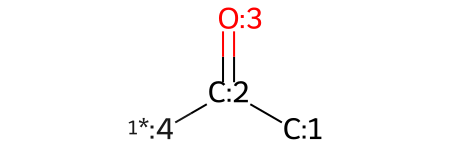

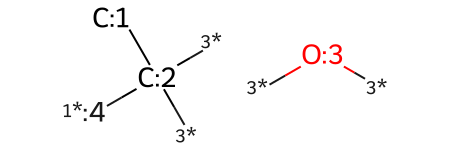

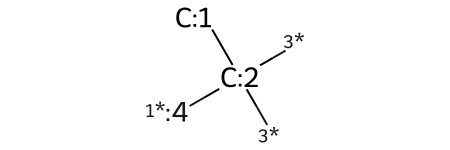

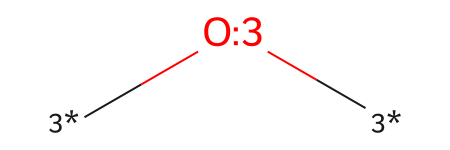

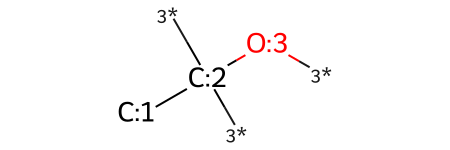

In [10]:
a1 = 2 - 1 # indices of atoms to target
a2 = 3 - 1 # indices of atoms to target
flavor_pair = (1, 3) # pair of port flavors to interface together

display(CARBONYL)
frags = dissolution.dissolve_bond(Chem.RWMol(CARBONYL), a1, a2, new_flavor_pair=(3,3))
MET, OXY = Chem.GetMolFrags(frags, asMols=True, sanitizeFrags=True)

display(frags)
display(MET)
display(OXY)

portlib.Port.bondable_flavors.insert(flavor_pair)
bondable_pair = identification.get_first_bondable_port_pair(frags, a1, a2, flavor_pair=flavor_pair)
prod1 = substitution.splice_atoms(frags, 1, 2, flavor_pair=(1,3), in_place=False)
display(prod1)

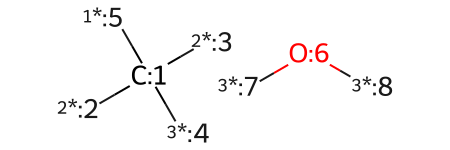

1


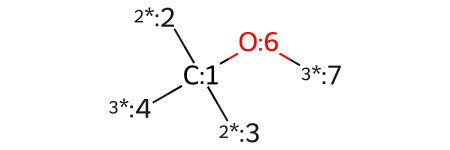

In [12]:
TEST = combined_rdmol(METHYL, OXY)
display(TEST)

order2 = identification.max_bondable_order_between_atoms(TEST, 0, 5, target_flavor=3)
prod2 = substitution.splice_atoms(TEST, 0, 5, flavor_pair=(1,3))

print(order2)
display(prod2)

## Testing port saturation

### Testing single bonds

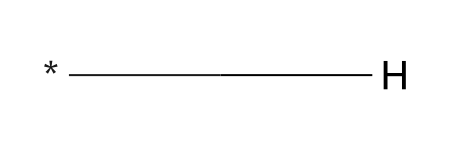

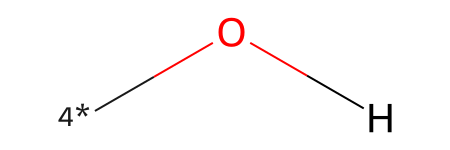

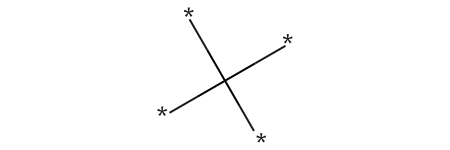

In [13]:
H_GENERIC = Chem.MolFromSmarts('[#1]-[#0]')
OH_GENERIC = Chem.MolFromSmarts('[#1]-[O]-[4#0]')
METHYL_GENERIC = Chem.MolFromSmarts('[#6](-[#0])(-[#0])(-[#0])(-[#0])')

display(H_GENERIC)
display(OH_GENERIC)
display(METHYL_GENERIC)

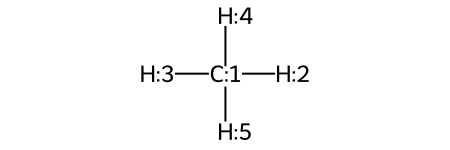

In [14]:
substitution.saturate_ports(METHYL_GENERIC, H_GENERIC)

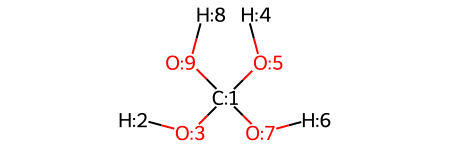

In [16]:
portlib.Port.bondable_flavors.insert((0,4))
substitution.saturate_ports(METHYL_GENERIC, OH_GENERIC)

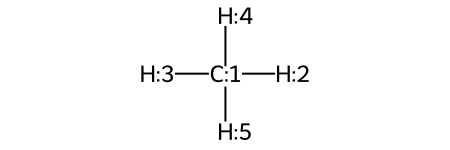

In [17]:
substitution.saturate_ports(METHYL_GENERIC, H_GENERIC)

### Testing double bonds

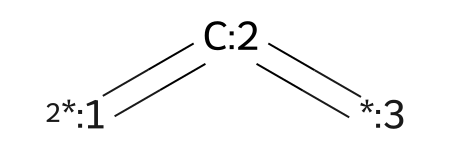

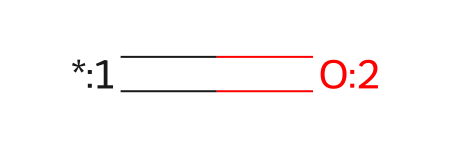

In [18]:
CARBENE = Chem.MolFromSmarts('[2#0:1]=[#6:2]=[#0:3]')
DIOX    = Chem.MolFromSmarts('[#0:1]=[#8:2]')

display(CARBENE)
display(DIOX)

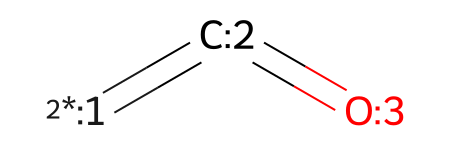

In [19]:
substitution.saturate_ports(CARBENE, cap=DIOX, flavor_to_saturate=2)

### Testing selectivity between mixed single and double bonds

In [ ]:
C3 = Chem.MolFromSmarts('[#6:1](=[#0:2])(-[#0:3])(-[#0:4])')
C3

In [ ]:
substitution.saturate_ports(C3, cap=DIOX)

### Testing the null case (no bonds formable, but with flavors matching)

In [ ]:
...

# Testing different measures of atom degree

In [20]:
from polymerist.polymers.monomers import specification

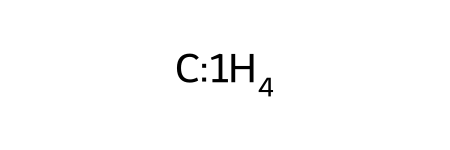

In [21]:
smiles = 'C'
exp_smiles = specification.expanded_SMILES(smiles)
mol = Chem.MolFromSmiles(exp_smiles)
mol

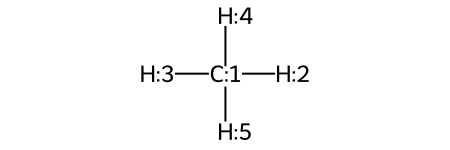

In [22]:
Chem.MolFromSmarts(exp_smiles)

In [23]:
specification.compliant_mol_SMARTS(exp_smiles)

2024-08-12 17:54:55.781 [WARNING :   specification:line 125 ] - Cleaned 5 SMARTS atom query aberrations introduced by RDKit


'[#6D4+0:1](-[#1D1+0:2])(-[#1D1+0:3])(-[#1D1+0:4])-[#1D1+0:5]'

In [27]:
import pandas as pd
from polymerist.genutils.iteration import iter_len

smarts = '[C]-[C]-[O]'
mol = Chem.MolFromSmarts(smarts)
Chem.SanitizeMol(mol)

records = []
for atom in mol.GetAtoms():
    record = {
        'symbol' : atom.GetSymbol(),
        'map num' : atom.GetAtomMapNum(),
        'num bonds' : iter_len(atom.GetBonds()),
        'impl_valence' : atom.GetImplicitValence(),
        'expl_valence' : atom.GetExplicitValence(),
        'total_valence' : atom.GetTotalValence(),
    }
    records.append(record)
df = pd.DataFrame.from_records(records)
df

,symbol,map num,num bonds,impl_valence,expl_valence,total_valence
0,C,0,1,3,1,4
1,C,0,2,2,2,4
2,O,0,1,1,1,2
